# Calibration of motor current

In [4]:
%matplotlib notebook

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd

from tools.data_loader import moving_average

import glob
import os

In [5]:
# get the .csv files for the given velocity limit
def get_files_for_limit(limit, flight, discard=True):
    
    v_induced = 14.345219306215128
    v_limit = limit * 0.01 * v_induced
    data_directory = flight + f'hover_{limit}_limit'
    csv_files = glob.glob(os.path.join(data_directory, "*.csv"))
    sorted_files = []

    # sort sequences in ascending order
    for i in range(len(csv_files)):
        for e in csv_files:
            if f'sequence_{i}_' in e:
                #print(e)
                sorted_files.append(e)
                break
    
    # discard first and land sequence (vehicle on ground before takeoff and after landing)
    if discard:
        return sorted_files[1:-1]
    
    else:
        return sorted_files
    

In [139]:
class Motor:
    
    def __init__(self, motorNumber):
        
        self.motorNumber = motorNumber
        self.currentESC = self.get_ESC_current(motorNumber)
        self.voltageESC = self.get_ESC_voltage(motorNumber)
        self.voltageMultimeter = self.get_multimeter_voltage(motorNumber)
        self.currentMultimeter = self.get_multimeter_current(motorNumber)
        
        self.timeCurrent = ((self.currentESC['t'].values - min(self.currentESC['t'].values)) / 10e5)
        self.timeVoltage = ((self.voltageESC['t'].values - min(self.voltageESC['t'].values)) / 10e5)

        self.omegaVoltage = self.voltageESC[f'omega{motorNumber}'].values
        self.omegaCurrent = self.currentESC[f'omega{motorNumber}'].values

        self.voltage = self.voltageESC[f'U1{motorNumber}'].values
        self.current = self.voltageESC[f'I1{motorNumber}'].values
        
        self.voltageSequences = self.get_voltage_sequence()
        self.currentSequences = self.get_current_sequence()

    @staticmethod
    def get_ESC_current(motorNumber):
        
        filepath = f'/home/gregor/Masterarbeit/flight_data/2022-08-08_test_rig/current_motor_{motorNumber}/' 
        filesCurrent = get_files_for_limit(10, filepath, discard=False)
        
        currentData = pd.DataFrame()
        
        for file in filesCurrent:
            currentData = pd.concat([currentData, pd.read_csv(file)])
        
        return currentData
    
    @staticmethod
    def get_ESC_voltage(motorNumber):
        
        filepath = f'/home/gregor/Masterarbeit/flight_data/2022-08-08_test_rig/voltage_motor_{motorNumber}/'
        filesVoltage = get_files_for_limit(10, filepath, discard=False)
        
        voltageData = pd.DataFrame()
        
        for file in filesVoltage:
            voltageData = pd.concat([voltageData, pd.read_csv(file)])
        
        return voltageData
    
    @staticmethod
    def get_multimeter_voltage(motorNumber):
        
        filepath = f'/home/gregor/Masterarbeit/flight_data/2022-08-08_test_rig/voltage_data.csv'
        voltage_measurements = pd.read_csv(filepath_voltage_measurements)
        
        return voltage_measurements.iloc[motorNumber-1].values

    @staticmethod
    def get_multimeter_current(motorNumber):
        
        folder = f'/home/gregor/Masterarbeit/flight_data/2022-08-08_test_rig/current_data_multimeter/'
        file = f'current_motor{motorNumber}.csv'
        
        current_measurement = pd.read_csv(folder+file)
        
        return current_measurement.values
    
    def get_current_sequence(self):
        
        relevantRpmValues = np.unique(self.omegaCurrent[self.omegaCurrent>=1000], return_counts=True) 
        frequentRpmValues = relevantRpmValues[0][relevantRpmValues[1] > 20]
        filteredIndices = np.nonzero(np.isin(self.omegaCurrent, frequentRpmValues)==1)[0]
        
        startMask = np.where(np.diff(filteredIndices,prepend=0)>10) # search for the gaps between the sequences
        sequenceStart = filteredIndices[startMask]

        endMask = np.where(np.abs(np.diff(np.flip(filteredIndices),prepend=0))>10)
        sequenceEnd = np.flip(np.flip(filteredIndices)[endMask])
        
        filteredCurrentSequence = []
        
        for i in range(sequenceStart.size):
    
            intersection = np.intersect1d(np.arange(sequenceStart[i],sequenceEnd[i]), filteredIndices)
            
            # remove first and last 5 values to get rid of outliers
            if not intersection.size == 0:
                filteredCurrentSequence.append(intersection[5:-5])
            
        return filteredCurrentSequence
    
    def get_voltage_sequence(self):
        
        relevantRpmValues = np.unique(self.omegaVoltage[self.omegaVoltage>=1000], return_counts=True) 
        frequentRpmValues = relevantRpmValues[0][relevantRpmValues[1] > 20]
        filteredIndices = np.nonzero(np.isin(self.omegaVoltage, frequentRpmValues)==1)[0]
        
        startMask = np.where(np.diff(filteredIndices,prepend=0)>10) # search for the gaps between the sequences
        sequenceStart = filteredIndices[startMask]

        endMask = np.where(np.abs(np.diff(np.flip(filteredIndices),prepend=0))>10)
        sequenceEnd = np.flip(np.flip(filteredIndices)[endMask])
        
        filteredVoltageSequence = []
        
        for i in range(sequenceStart.size):
    
            intersection = np.intersect1d(np.arange(sequenceStart[i],sequenceEnd[i]), filteredIndices)
            
            # remove first and last 5 values to get rid of outliers
            if not intersection.size == 0:
                filteredVoltageSequence.append(intersection[5:-5])
            
        return filteredVoltageSequence

In [43]:
#def get_motor_data():
#    
#    motor_data = []
#    
#    for i in range(8):
#        filepath_voltage = f'/home/gregor/Masterarbeit/flight_data/2022-08-08_test_rig/voltage_motor_{motor}/'
#        filepath_current = f'/home/gregor/Masterarbeit/flight_data/2022-08-08_test_rig/current_motor_{motor}/'
#        
#        files_current = get_files_for_limit(10, filepath_current, discard=False)
#        files_voltage = get_files_for_limit(10, filepath_voltage, discard=False)
#
#        current_data = pd.DataFrame()
#        voltage_data = pd.DataFrame()
#
#        # stack sequences
#        for file in files_current:
#            current_data = pd.concat([current_data, pd.read_csv(file)])
#
#        for file in files_voltage:
#            voltage_data = pd.concat([voltage_data, pd.read_csv(file)])

In [112]:
motor = 1

filepath_voltage = f'/home/gregor/Masterarbeit/flight_data/2022-08-08_test_rig/voltage_motor_{motor}/'
filepath_current = f'/home/gregor/Masterarbeit/flight_data/2022-08-08_test_rig/current_motor_{motor}/'

files_current = get_files_for_limit(10, filepath_current, discard=False)
files_voltage = get_files_for_limit(10, filepath_voltage, discard=False)

current_data = pd.DataFrame()
voltage_data = pd.DataFrame()

# stack sequences
for file in files_current:
    current_data = pd.concat([current_data, pd.read_csv(file)])
    
for file in files_voltage:
    voltage_data = pd.concat([voltage_data, pd.read_csv(file)])

In [113]:
filepath_voltage_measurements = f'/home/gregor/Masterarbeit/flight_data/2022-08-08_test_rig/voltage_data.csv'
voltage_measurements = pd.read_csv(filepath_voltage_measurements)

In [114]:
voltage_measured = voltage_measurements.iloc[motor-1].values
voltage_measured

array([32.37, 32.23, 32.  , 31.67, 31.25])

In [115]:
#flight_data.rename(columns = {' omega1':'omega1'}, inplace = True)

t_current = ((current_data['t'].values - min(current_data['t'].values)) / 10e5)
t_voltage = ((voltage_data['t'].values - min(voltage_data['t'].values)) / 10e5)

omega_voltage = voltage_data[f'omega{motor}'].values
omega_current = current_data[f'omega{motor}'].values

voltage = voltage_data[f'U1{motor}'].values
current = current_data[f'I1{motor}'].values

#control_voltage = voltage_data[f'ctrl_{motor}'].values
#control_current = current_data[f'ctrl_{motor}'].values

In [116]:
# get count of unique values
unique_rpms_voltage = np.unique(omega_voltage[omega_voltage>=1000], return_counts=True) # all unique RPMs above 1000
filtered_rpms_voltage = unique_rpms_voltage[0][unique_rpms_voltage[1] > 20] # Only RPM that occur more than 20 times
filtered_voltage_indices = np.nonzero(np.isin(omega_voltage, filtered_rpms_voltage)==1)[0] # apply filter

# get count of unique values
unique_rpms_current = np.unique(omega_current[omega_current>=1000], return_counts=True) 
filtered_rpms_current = unique_rpms_current[0][unique_rpms_current[1] > 20]
filtered_current_indices = np.nonzero(np.isin(omega_current, filtered_rpms_current)==1)[0]

# get start and ends of sequence

In [117]:
mask = np.where(np.diff(filtered_voltage_indices,prepend=0)>10) # search for the gaps between the sequences
start_voltage = filtered_voltage_indices[mask]

mask = np.where(np.abs(np.diff(np.flip(filtered_voltage_indices),prepend=0))>10)
end_voltage = np.flip(np.flip(filtered_voltage_indices)[mask])

mask = np.where(np.diff(filtered_current_indices,prepend=0)>10) # search for the gaps between the sequences
start_current = filtered_current_indices[mask]

mask = np.where(np.abs(np.diff(np.flip(filtered_current_indices),prepend=0))>10)
end_current = np.flip(np.flip(filtered_current_indices)[mask])

In [118]:
# get index arrays for every sequence
volt_sequences = start_voltage.size
curr_sequences = start_current.size
seq_idx_current = []
seq_idx_voltage = []

for i in range(volt_sequences):
    
    intersection = np.intersect1d(np.arange(start_voltage[i],end_voltage[i]), filtered_voltage_indices)
    
    if not intersection.size == 0:
        seq_idx_voltage.append(intersection[5:-5]) # remove first and last 5 values to get rid of outliers

for i in range(curr_sequences):
    
    intersection = np.intersect1d(np.arange(start_current[i],end_current[i]), filtered_current_indices)
    
    if not intersection.size == 0:
        seq_idx_current.append(intersection[5:-5]) # remove first and last 5 values to get rid of outliers

In [137]:
len(seq_idx_voltage)

5

In [138]:
len(motor[0].voltageSequences)

4

In [140]:
motor = []
for i in range(1,9):
    motor.append(Motor(i))

<IPython.core.display.Javascript object>


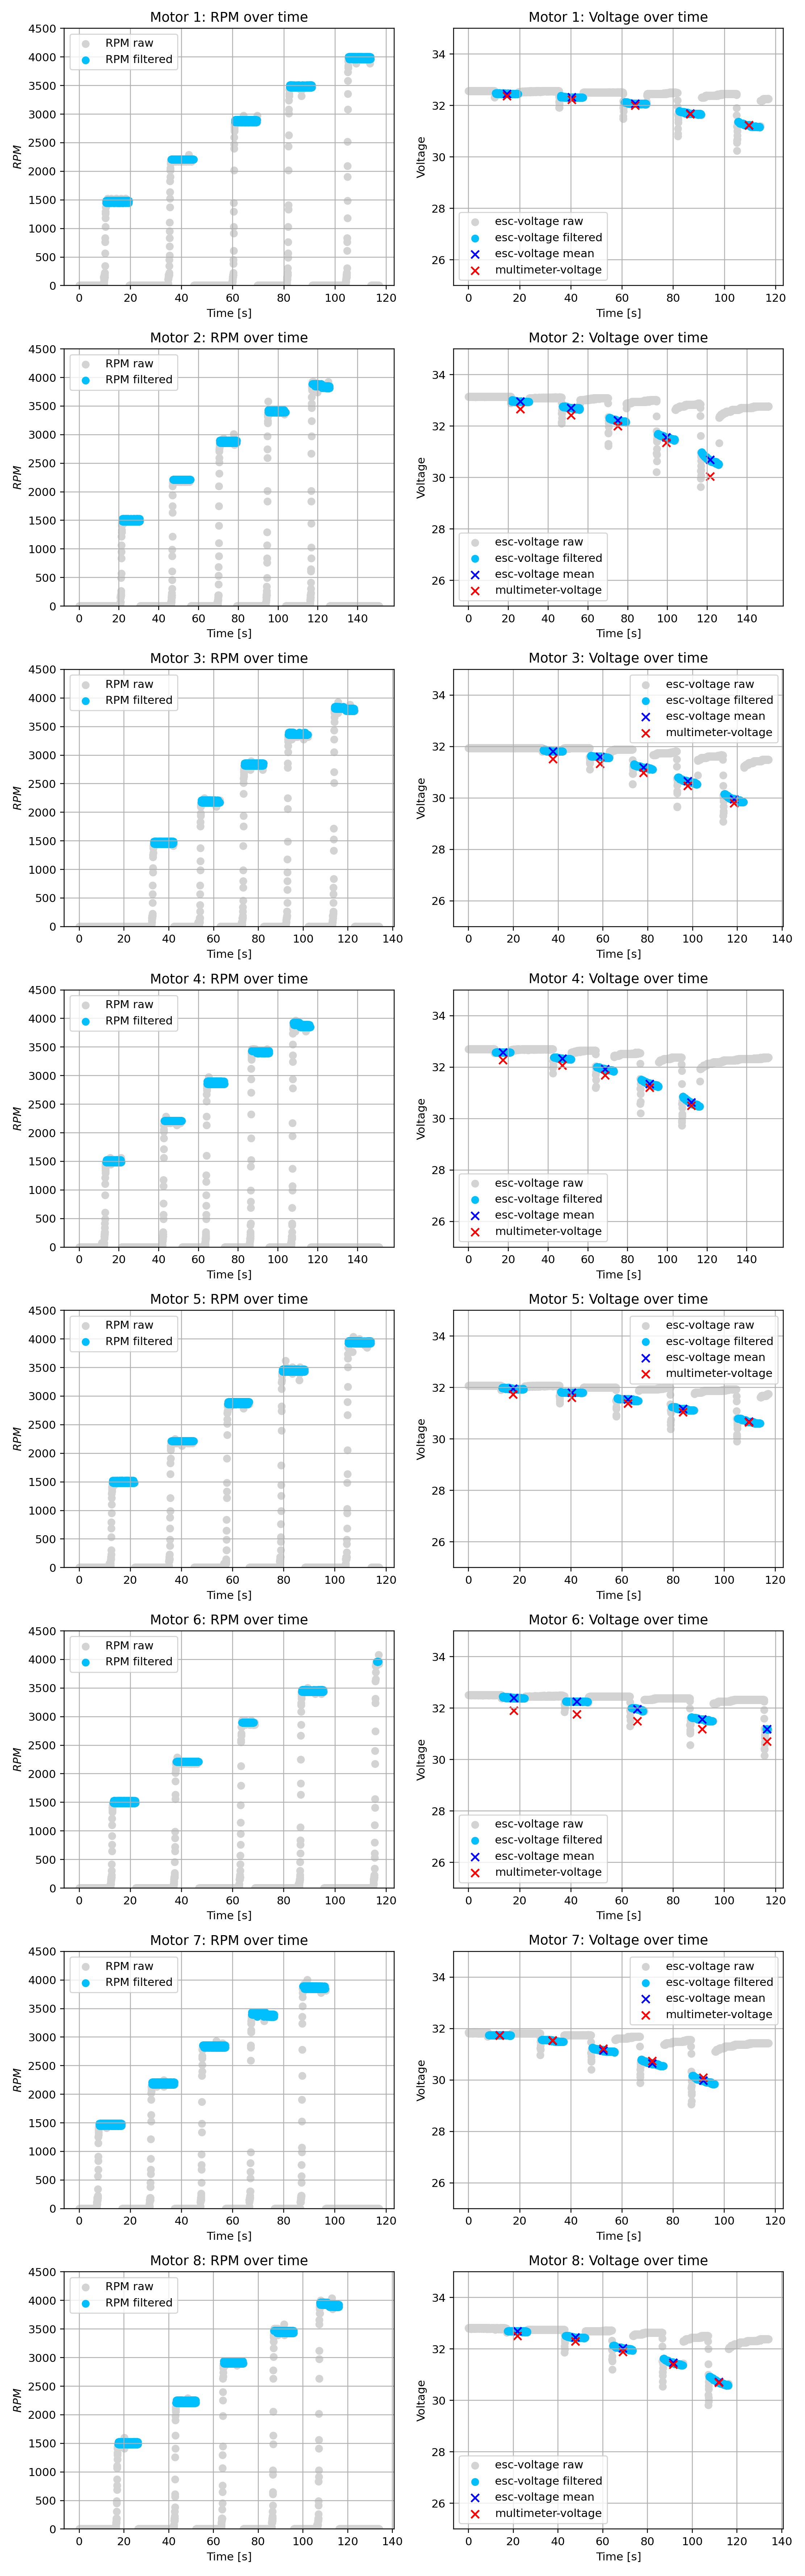

In [145]:
# motor cmds

n_motors = 8
fig0, ax0 = plt.subplots(n_motors,2, figsize=(10,4*n_motors))

# raw data
for i in range(n_motors):
    ax0[i][0].scatter(motor[i].timeVoltage, motor[i].omegaVoltage, color='lightgray', label='RPM raw')
    ax0[i][1].scatter(motor[i].timeVoltage, motor[i].voltage, color='lightgray', label='esc-voltage raw')

    # plot the sequences 

    for j, seq in enumerate(motor[i].voltageSequences):

        time = motor[i].timeVoltage[seq]
        omega =  motor[i].omegaVoltage[seq]
        voltage = motor[i].voltage[seq]
        t = (max(time) + min(time))/2
        mean_voltage = np.mean(voltage)

        if(j==0):
            ax0[i][0].scatter(time, omega, color='deepskyblue', label = 'RPM filtered')
            ax0[i][1].scatter(time, voltage, color='deepskyblue', label='esc-voltage filtered')
            ax0[i][1].scatter(t, mean_voltage, s=50, marker='x', color='b', label='esc-voltage mean')
            ax0[i][1].scatter(t, motor[i].voltageMultimeter[j], s=50, marker='x', color='r',label='multimeter-voltage')
        else:
            ax0[i][0].scatter(time, omega, color='deepskyblue')
            ax0[i][1].scatter(time, voltage, color='deepskyblue')
            ax0[i][1].scatter(t, mean_voltage, s=50, marker='x', color='b')
            ax0[i][1].scatter(t, motor[i].voltageMultimeter[j], s=50, marker='x', color='r')
    
    ax0[i][0].set_xlabel('Time [s]')
    ax0[i][0].set_ylabel('$RPM$')
    ax0[i][0].set_ylim(0,4500)
    ax0[i][0].grid()
    ax0[i][0].legend()

    ax0[i][1].set_xlabel('Time [s]')
    ax0[i][1].set_ylabel('Voltage')
    ax0[i][1].set_ylim(25,35)
    ax0[i][1].grid()
    ax0[i][1].legend()

    #ax0[i][0].set_ylim(0,4500)
    #ax0[1][0].set_ylim(0,4500)

    ax0[i][0].set_title(f'Motor {i+1}: RPM over time')
    ax0[i][1].set_title(f'Motor {i+1}: Voltage over time')
    #ax0[1][0].set_title(f'RPM over time')
    #ax0[1][1].set_title(f'Current over time')
fig0.tight_layout()